# Install dependencies

In [ ]:
!pip install pillow           # For PIL (Python Imaging Library)
!pip install numpy            # For numpy (though usually included with Jupyter)
!pip install scikit-learn     # For sklearn
!pip install tensorflow       # For keras (now part of TensorFlow)
!pip install scipy            # For scipy.ndimage
!pip install matplotlib       # For matplotlib.pyplot

# Run this if you are on linux

In [ ]:
sudo apt-get install python3-tk

# Importing important libraries

In [12]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from scipy.ndimage import center_of_mass, shift
from tensorflow.keras.datasets import mnist
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt

# To read images/ prepare feature vector and convert labels to one hot encoded vectors

In [2]:
def one_hot_encode(labels):
    """
    Convert labels into one-hot encoded vectors.
    
    Parameters:
        labels: List or 1D array of integers (0-9).

    Returns:
        one_hot_labels: 2D NumPy array of shape (n_samples, 10).
    """
    n_samples = len(labels)
    one_hot_labels = np.zeros((n_samples, 10))
    one_hot_labels[np.arange(n_samples), labels] = 1
    return one_hot_labels

def get_dct_matrix(N):
    '''
    Get an NxN DCT matrix to compute the DCT coefficients for image patches of size NxN
    '''
    C = np.zeros((N, N))
    for k in range(N):
        for n in range(N):
            alpha = np.sqrt(1/N) if k == 0 else np.sqrt(2/N)
            C[k, n] = alpha * np.cos((np.pi * (2 * n + 1) * k) / (2 * N))
    return C

C = get_dct_matrix(28)


def DCT(image):
    """
    Extract the DCT coefficients as features for every 7x7 grid of the image.

    Parameters:
        image: 2D NumPy array (28x28) - grayscale image.

    Returns:
        features: 1D NumPy array - DCT features for the image.
    """
    features = []
    
    D = C @ image @ C.T

    features.extend(D.flatten())
            
    return np.array(features)


def preprocess(x,y):
    """
    Loads MNIST dataset, centers digits using center of mass, extracts DCT features.

    Returns:
        features_array: 2D NumPy array (n_samples, N) - DCT features per image.
        one_hot_labels: 2D NumPy array (n_samples, 10) - one-hot encoded labels.
    """
    x = x / 255.0  # Normalize

    features_list = []
    labels_list = []

    for image, label in zip(x, y):
        # Center by center of mass
        cy, cx = center_of_mass(image)
        dy, dx = 13.5 - cy, 13.5 - cx
        centered_image = shift(image, shift=(dy, dx), order=1, mode='constant', cval=0.0)
        
        # Extract DCT features
        features = DCT(centered_image)

        features_list.append(features)
        labels_list.append(label)

    features_array = np.array(features_list)
    one_hot_labels = one_hot_encode(labels_list)

    return features_array, one_hot_labels

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
x_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((Y_train, Y_test))

#Preprocessed Data
features_array, one_hot_labels = preprocess(x_full, y_full)
one_hot_labels_train = one_hot_labels[:60000,:]
one_hot_labels_val = one_hot_labels[60000:,:]

print("Feature Array Shape:", features_array.shape) 
print("One-Hot Labels Shape:", one_hot_labels.shape) 

Feature Array Shape: (70000, 784)
One-Hot Labels Shape: (70000, 10)


# Performing Principal Component Analysis 

In [3]:
def PCA(features):
    '''
    Extracts top K principal components that account for 95% of the variation in the data using SVD.

    Parameters:
        features: 2D NumPy array of shape (n_samples, n_features)

    Returns:
        projected_features: data projected onto top K components
        principal_components: the top K principal axes (eigenvectors)
        loading_scores: singular values indicating variance explained
    '''
    # Step 1: Mean center the data
    mean_vector = np.mean(features, axis=0)
    centered = features - mean_vector

    # Step 2: SVD
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)

    # Step 3: Explained variance
    explained_variance = (S ** 2) / (len(features) - 1)
    total_variance = np.sum(explained_variance)
    explained_variance_ratio = explained_variance / total_variance
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Step 4: Select K components for 95% variance
    K = np.argmax(cumulative_variance >= 0.90) + 1
    principal_components = Vt[:K]           # Top K principal components
    loading_scores = S[:K]                  # Top K singular values

    # Step 5: Project the data onto top K components
    projected_features = np.array(centered @ principal_components.T)
    return projected_features, principal_components, loading_scores, mean_vector

projected_features, principal_components, loading_scores, mean_vector = PCA(features_array)

projected_features_train = projected_features[:60000,:]
projected_features_val = projected_features[60000:,:]

print(f"Shape of dataset features: {projected_features.shape}\n")
print(f"Loading scores of the top k principal components that capture 90% of the variance: \n\n{loading_scores}")

Shape of dataset features: (70000, 57)

Loading scores of the top k principal components that capture 90% of the variance: 

[591.95486371 496.72450502 464.85806692 434.69517635 417.01240171
 384.85711255 337.17878171 307.51873431 306.3179908  279.1899539
 262.5701641  253.01280653 238.08819502 232.38126951 224.94158839
 220.32405562 203.16230821 199.25243405 193.00703355 187.45496236
 181.10519754 173.49742207 172.00089914 166.22967789 162.68113245
 160.23535117 156.99928314 154.26632453 148.78069718 143.58329023
 138.01108097 137.66895579 131.9712809  127.62667464 126.16249162
 124.6573286  121.15632294 117.14699476 116.74779702 115.89052725
 112.43208652 111.98470977 106.24186589 104.84666169 103.82479137
 102.29474751  98.62750212  97.40448306  96.86908008  92.87498114
  90.70077871  89.7950877   88.74093265  87.45337301  85.20835083
  83.90694706  83.56084151]


# ReLu and it's derivative

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(z):
    return (z > 0).astype(float)

# Softmax Function

In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function

In [6]:
def cross_entropy_loss(y_true, y_pred):
    # Categorical cross-entropy loss with small value epsilon to avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Adam optimizer

In [7]:
def adam_update(param, grad, m, v, t, lr):
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * np.square(grad)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)
    return param, m, v

# Training the NN

In [8]:
# Initialize neural network parameters
input_size = 57
hidden_layer_1_size = 828
hidden_layer_2_size = 512
output_size = 10
learning_rate = 0.0015
epochs = 8
batch_size = 64

# Random seed for reproducibility
np.random.seed(42)

# Initialize weights and biases
w1 = np.random.randn(input_size, hidden_layer_1_size) * 0.01
b1 = np.zeros((1, hidden_layer_1_size))

w2 = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) * 0.01
b2 = np.zeros((1, hidden_layer_2_size))

w3 = np.random.randn(hidden_layer_2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))


# Adam optimizer state variables (momentum, velocity)
m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_w3, v_w3 = np.zeros_like(w3), np.zeros_like(w3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)

beta1, beta2 = 0.9, 0.999  # Adam parameters
epsilon = 1e-8  # For numerical stability

# Learning rate decay
lr_scheduler = lambda epoch: learning_rate * max(0.90 ** epoch, 1e-6)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(projected_features_train, one_hot_labels_train, test_size=0.2, random_state=42)

loss_history = []
val_loss_history = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = int(x_train.shape[0] / batch_size)
    
    for batch in range(num_batches):
        # Get the current batch
        start = batch * batch_size
        end = start + batch_size
        X_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Forward pass
        z1 = np.dot(X_batch, w1) + b1
        a1 = relu(z1)
        
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        
        z3 = np.dot(a2, w3) + b3
        
        y_pred = softmax(z3)

        # Calculate loss
        loss = cross_entropy_loss(y_batch, y_pred)
        epoch_loss += loss
        
        # Calculate accuracy
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        epoch_accuracy += accuracy

        # Backpropagation
        # Output layer gradients
        dz3 = y_pred - y_batch  # Gradient of loss w.r.t output layer
        dw3 = np.dot(a2.T, dz3) / batch_size
        db3 = np.sum(dz3, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 2 gradients
        dz2 = np.dot(dz3, w3.T) * relu_derivative(a2)
        dw2 = np.dot(a1.T, dz2) / batch_size
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 1 gradients
        dz1 = np.dot(dz2, w2.T) * relu_derivative(a1)
        dw1 = np.dot(X_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

        w1, m_w1, v_w1 = adam_update(w1, dw1, m_w1, v_w1, epoch+1, lr_scheduler(epoch))
        b1, m_b1, v_b1 = adam_update(b1, db1, m_b1, v_b1, epoch+1, lr_scheduler(epoch))

        w2, m_w2, v_w2 = adam_update(w2, dw2, m_w2, v_w2, epoch+1, lr_scheduler(epoch))
        b2, m_b2, v_b2 = adam_update(b2, db2, m_b2, v_b2, epoch+1, lr_scheduler(epoch))

        w3, m_w3, v_w3 = adam_update(w3, dw3, m_w3, v_w3, epoch+1, lr_scheduler(epoch))
        b3, m_b3, v_b3 = adam_update(b3, db3, m_b3, v_b3, epoch+1, lr_scheduler(epoch))

    # Epoch metrics
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss/num_batches:.4f}, Accuracy: {epoch_accuracy/num_batches:.4f}")
    
    # Validation loss and accuracy after every epoch
    z1_val = np.dot(x_test, w1) + b1
    a1_val = relu(z1_val)
    z2_val = np.dot(a1_val, w2) + b2
    a2_val = relu(z2_val)
    z3_val = np.dot(a2_val, w3) + b3
    y_pred_val = softmax(z3_val)
    
    val_loss = cross_entropy_loss(y_test, y_pred_val)
    val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_test, axis=1))

    loss_history.append(loss)
    val_loss_history.append(val_loss)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Learning rate: {lr_scheduler(epoch)}","\n")

Epoch 1/8 - Loss: 0.1875, Accuracy: 0.9451
Validation Loss: 0.0930, Validation Accuracy: 0.9708
Learning rate: 0.0015 

Epoch 2/8 - Loss: 0.0610, Accuracy: 0.9820
Validation Loss: 0.0699, Validation Accuracy: 0.9785
Learning rate: 0.00135 

Epoch 3/8 - Loss: 0.0403, Accuracy: 0.9885
Validation Loss: 0.0624, Validation Accuracy: 0.9824
Learning rate: 0.0012150000000000002 

Epoch 4/8 - Loss: 0.0296, Accuracy: 0.9923
Validation Loss: 0.0589, Validation Accuracy: 0.9830
Learning rate: 0.0010935 

Epoch 5/8 - Loss: 0.0228, Accuracy: 0.9948
Validation Loss: 0.0571, Validation Accuracy: 0.9837
Learning rate: 0.00098415 

Epoch 6/8 - Loss: 0.0180, Accuracy: 0.9962
Validation Loss: 0.0562, Validation Accuracy: 0.9842
Learning rate: 0.0008857350000000001 

Epoch 7/8 - Loss: 0.0145, Accuracy: 0.9973
Validation Loss: 0.0559, Validation Accuracy: 0.9843
Learning rate: 0.0007971615000000001 

Epoch 8/8 - Loss: 0.0118, Accuracy: 0.9981
Validation Loss: 0.0559, Validation Accuracy: 0.9847
Learning ra

# Performance metrics

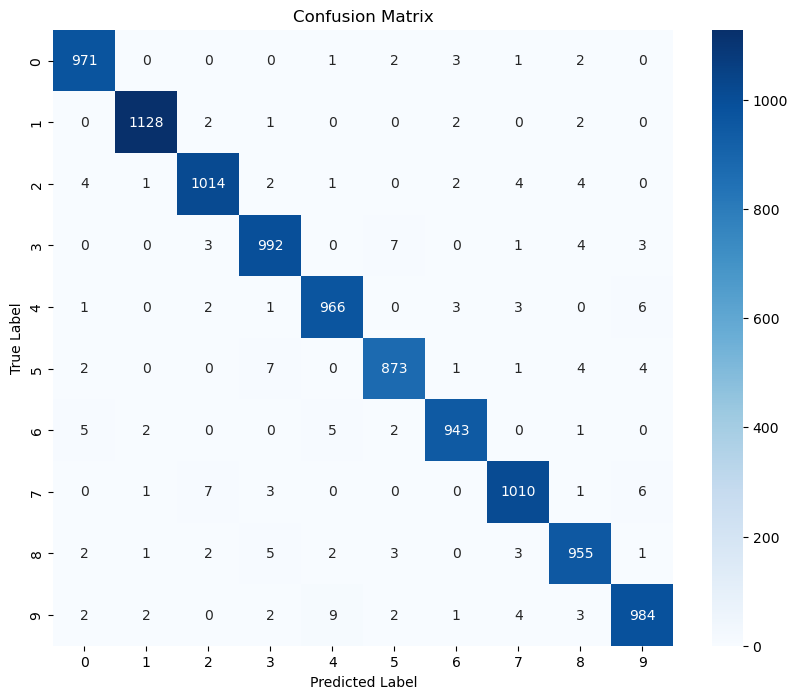

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



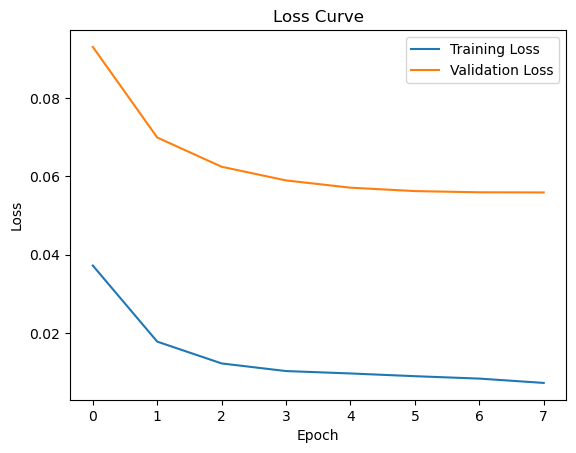

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Predict on validation/test set
z1_val = np.dot(projected_features_val, w1) + b1
a1_val = np.maximum(0, z1_val)
z2_val = np.dot(a1_val, w2) + b2
a2_val = np.maximum(0, z2_val)
z3_val = np.dot(a2_val, w3) + b3
y_pred_val = softmax(z3_val)
y_pred_labels = np.argmax(y_pred_val, axis=1)
y_true_labels = np.argmax(one_hot_labels_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Loss Curve (if you stored epoch_loss values)
plt.plot(loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Draw the digit to be predicted

2025-04-28 12:50:27.256 python[2691:161591] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-28 12:50:27.256 python[2691:161591] +[IMKInputSession subclass]: chose IMKInputSession_Modern


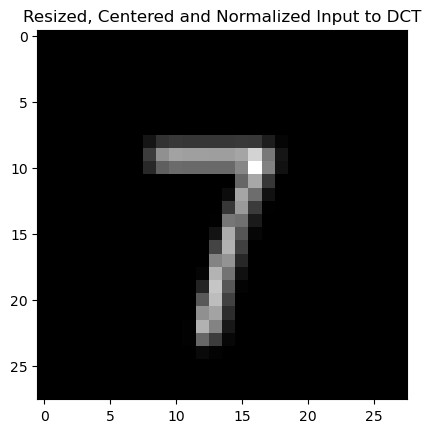

Predicted Digit: 7


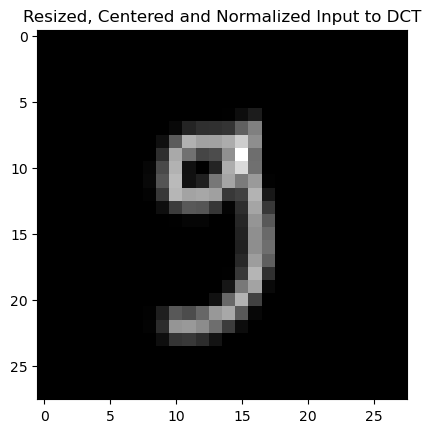

Predicted Digit: 9


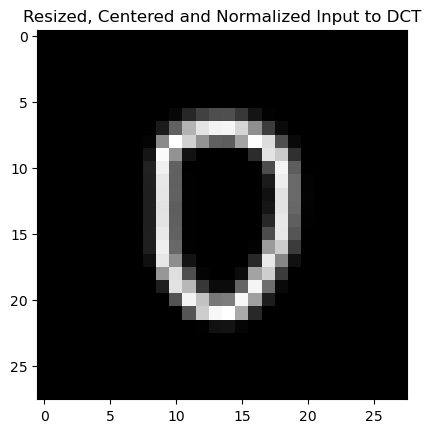

Predicted Digit: 7


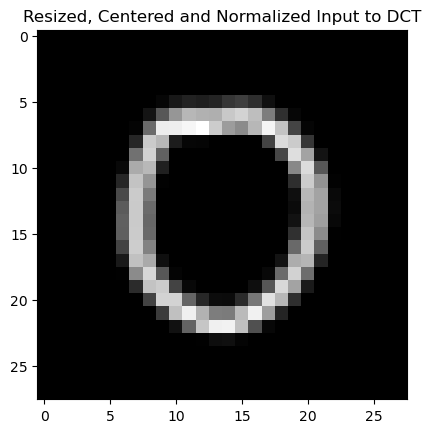

Predicted Digit: 0


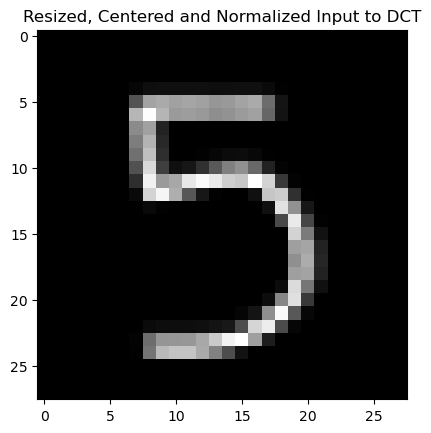

Predicted Digit: 5


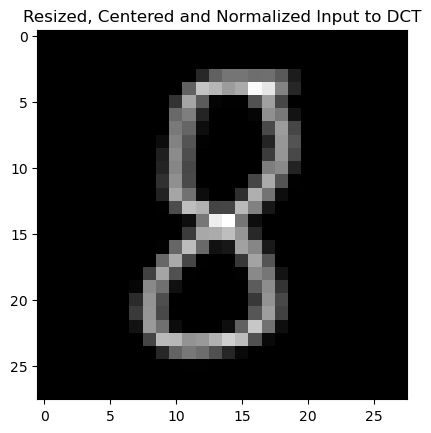

Predicted Digit: 8


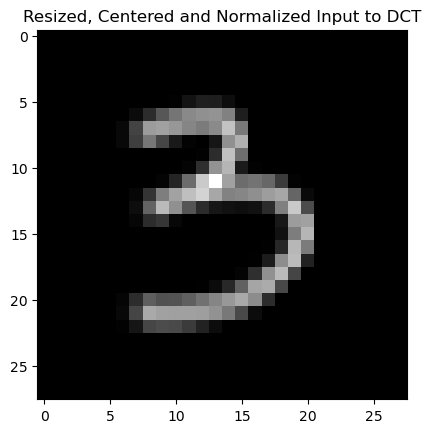

Predicted Digit: 3


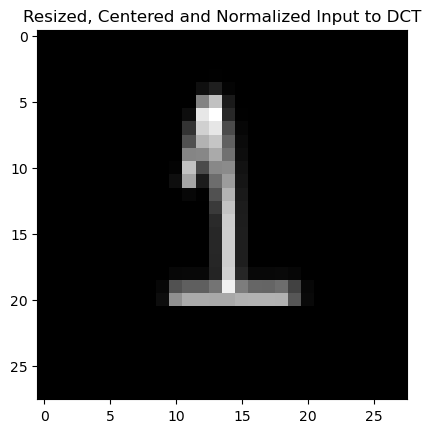

Predicted Digit: 1


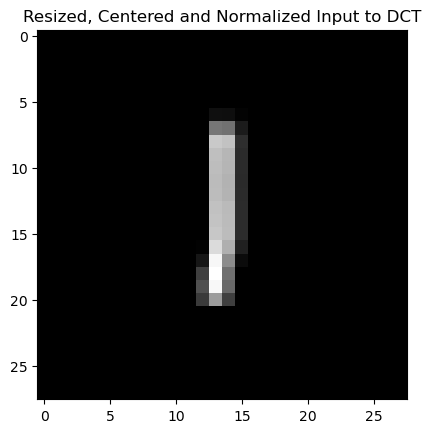

Predicted Digit: 1


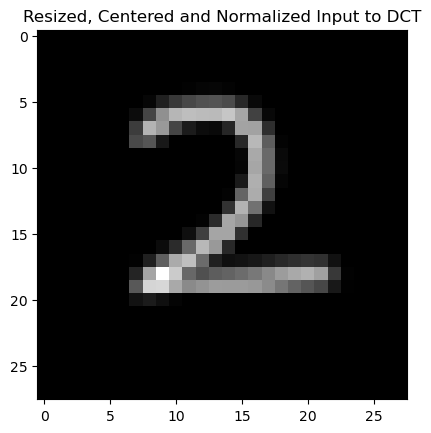

Predicted Digit: 2


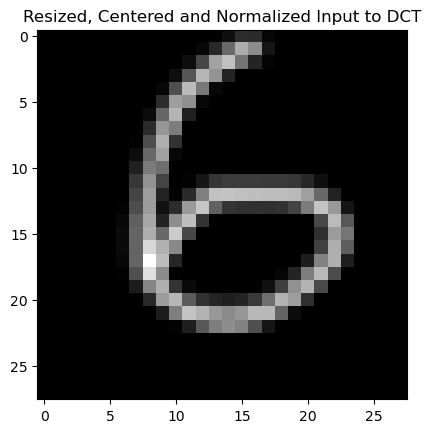

Predicted Digit: 6


In [13]:
# --- Tkinter canvas setup ---
canvas_width = 500
canvas_height = 500
white = (255, 255, 255)

root = tk.Tk()
root.title("Draw a Digit")
canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg='black')
canvas.pack()

image1 = Image.new("L", (canvas_width, canvas_height), color=0)
draw = ImageDraw.Draw(image1)

def paint(event):
    x1, y1 = (event.x - 7), (event.y - 7)
    x2, y2 = (event.x + 7), (event.y + 7)
    canvas.create_oval(x1, y1, x2, y2, fill="white", width=0)
    draw.ellipse([x1, y1, x2, y2], fill=255)

canvas.bind("<B1-Motion>", paint)

# --- Helper Functions ---
def preprocess_and_predict(img):
    img = img.resize((28, 28))
    img = np.array(img) / 255.0

    cy, cx = center_of_mass(img)
    dy, dx = 13.5 - cy, 13.5 - cx
    centered_img = shift(img, shift=(dy, dx), order=1, mode='constant', cval=0.0)
    
    plt.imshow(centered_img, cmap='gray')
    plt.title("Resized, Centered and Normalized Input to DCT")
    plt.show()

    features = DCT(centered_img)
    features = features.reshape(1, -1)

    # Center and project using saved PCA info
    centered = features - mean_vector
    pca_features = centered @ principal_components.T

    # Forward pass
    z1 = np.dot(pca_features, w1) + b1
    a1 = np.maximum(0, z1)
    z2 = np.dot(a1, w2) + b2
    a2 = np.maximum(0, z2)
    z3 = np.dot(a2, w3) + b3
    y_pred = softmax(z3)
    prediction = np.argmax(y_pred)
    
    print(f"Predicted Digit: {prediction}")

def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, canvas_width, canvas_height], fill=0)

# --- Buttons ---
tk.Button(root, text="Predict", command=lambda: preprocess_and_predict(image1.copy())).pack()
tk.Button(root, text="Clear", command=clear_canvas).pack()

root.mainloop()